# Ising2D

This notebook contains code and examples to run interactive simulations of a 2D Ising model.

First we'll import the two libraries we need: `numpy` and `matplotlib`.

In [26]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets

Then we will define the basic functions that we need to do the sampling of the 2D Ising model.

The first is the Metropolis function, which allows us to accept or reject a Monte Carlo step.

In [2]:
def metropolis (beta,H_initial,H_final) :
    """
    Metropolis Monte Carlo basic step. User provides 'beta', the inverse
    temperature, and the two energies 'H_initial' and 'H_final'. Returns
    True or False depending on whether the move was accepted or rejected.
    """
    if H_final <= H_initial :
        return True
    else :
        if (np.random.rand() < np.exp (-beta*(H_final-H_initial))) :
            return True
        else :
            return False

We also need an auxiliary function that will allow us to enforce our site numbering scheme: translates the index of the spin to the row and column index of the lattice.

In [3]:
def site2d_idx(I, n) :
    """
    Returns the row and column indices of site I on a lattice of
    n spins per edge.
    """
    return I//n, I%n

We then define a class that contains all the necessary code to perform a Monte Carlo simulation of the model.

In [27]:
class TwoDIsingModel :
    
    def __init__(self, n, J, b, T, vis=False) :
        """
        User initializes the class with the parameters:
        - n: size of the edge of the lattice. Total number of
             spins will be N = n*n
        - J: the coupling strength between the spins
        - b: the external field
        - T: the temperature (unitless)
        
        Optional parameter:
        - vis: True if we want to perform a live simulation
        """
        
        # initialize the parameters of the model
        self.n = n
        self.N = N = n*n
        self.J = J
        self.b = b
        self.T = T
        self.vis = vis
        self.beta = 1.0/T
        
        # initialize the vector of spins
        self.spins = np.random.choice([-1, 1], size=N)
        
        # prepare neighbors matrix
        W = np.zeros((N,4), dtype=np.int32)
        for I in xrange(N) :

            # row and column index of this site
            i,j = site2d_idx(I, n)

            # connect site to its left neighbor
            if j>0 :
                W[I,0] = I-1
            else :
                W[I,0] = n-1+n*i

            # connect site to its right neighbor
            if j==n-1 :
                W[I,1] = n*i
            else :
                W[I,1] = I+1

            # connect site to its top neighbor
            if i>0 :
                W[I,2] = I-n
            else :
                W[I,2] = n*(n-1)+j

            # connect site to its bottom neighbor
            if i==n-1 :
                W[I,3] = j
            else :
                W[I,3] = I+n
        
        # set it to an internal variable
        self.neighbors = W
        
        # set the spin grid
        self.s = np.zeros((self.n, self.n))
        
        # set the self image
        if vis :
            self.fig, self.ax = plt.subplots(dpi=100, figsize=(5,5))
            plt.axis('off')
            self.im = self.ax.imshow(self.spingrid, cmap=plt.cm.Greys)
    
    @property
    def spingrid(self) :
        for I in xrange(self.N) :
            i,j = site2d_idx(I, self.n)
            self.s[i,j] = self.spins[I]
        return self.s
    
    @spingrid.setter
    def spingrid(self, value) :
        self.s = value
    
    def spin_energy(self, i) :
        E = b
        for j in self.neighbors[i] :
            E += J*self.spins[j]
        E *= -self.spins[i]
        return E
            
    def step(self) :
        
        found = False
        while not found :
            # select one of the spins at random
            n = np.random.randint(0, self.N)

            # calculate the initial energy of the spin, then flip it
            Ein = self.spin_energy(n)
            self.spins[n] *= -1   # flip it

            # calculate the final energy of the spin, 
            # and apply Metropolis criterion
            Efin = self.spin_energy(n)
            found = metropolis(self.beta, Ein, Efin)
            
            # if the Metropolis criterion fails to give a valid step, 
            # we put back the spin to its original state
            if not found :
                self.spins[n] *= -1
    
    def energy(self) :
        return 0.5*sum([self.spin_energy(i) for i in xrange(self.N)])
    
    def run(self, nsteps, teq, tsample, tvis=1000) :
        
        # init vectors that will hold the sampling data
        nsamples = int((nsteps-teq)/tsample)
        self.m = np.zeros(nsamples)
        self.e = np.zeros(nsamples)

        # simulation loop
        count = 0
        for step in xrange(nsteps) :
            
            # make one step
            self.step()
        
            # collect samples if the step is larger than
            # the equilibration time and the step is a multiple
            # of the sampling time
            if step > teq and step%tsample==0 :
                self.m[count] = self.spins.mean()
                self.e[count] = self.energy()
                count += 1
            
            # visualize if a suitable routine is passed
            if self.vis :
                if step%tvis==0 :
                    self.visualize()
        
    def visualize(self) :
        """
        Update the plot of the state of the system
        """
        try :
            self.im.set_data(self.spingrid)
            self.fig.canvas.draw()
        except AttributeError :
            raise ValueError("Please init the class with 'vis=True'")

Now we have the code ready. The next thing is to initialize the `TwoDIsingModel` class with the parameters that we want, and run a simulation.

We prepare the widgets from the `ipywidgets` library so we can control the parameters of the simulations easily.

<IPython.core.display.Javascript object>


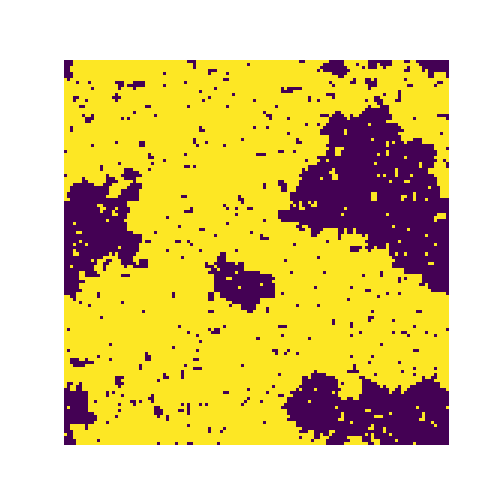

In [25]:
%matplotlib notebook

# interval at which the simulation results are visualized
nsteps = 100000
teq = 10000
tsample = 10000
tvis = 1000

# init the lattice of size N*N
def run_twoD_ising(n, J, b, T) :
    
    # initialize the model
    twoD_ising = TwoDIsingModel(n, J, b, T, vis=True)
    
    # run a simulation
    twoD_ising.run(nsteps, teq, tsample, tvis)
            
n_options = ipywidgets.Dropdown(
                                options=[64, 128, 256],
                                value=128,
                                description='Lattice size',
                                disabled=False,
                                )

T_text = ipywidgets.FloatText(value=2.2,
                              description='Temperature',
                              disabled=False
                              )

b_text = ipywidgets.FloatText(value=0.0,
                              description='Field',
                              disabled=False
                              )

w_text = ipywidgets.FloatText(value=1.0,
                              description='Coupling strength',
                              disabled=False
                              )

ipywidgets.interact(run_twoD_ising, n=n_options, T=T_text, b=b_text, w=w_text)